In [29]:
!pip install ipympl
!pip install xarray netCDF4 cartopy matplotlib

In [30]:
!pip install openeo

In [31]:
!pip install folium

In [32]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import openeo
import json
import folium

In [33]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [34]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field

dates = ["2023-06-01", "2023-10-30"]
aoi = read_json("don.geojson") # read_json("sentinel_5p_co_extent.geojson")

In [35]:
m = folium.Map([58.932, 5.637], zoom_start = 4)
folium.GeoJson(aoi).add_to(m)
m

In [38]:
'''
lst = connection.load_collection(
    collection_id='SENTINEL_5P_L2',
    spatial_extent={
        "type": "Polygon",
        "coordinates": [
          [
                [5.50, 57.56],  
                [11.0, 58.5],  
                [13.0, 60.0],  
                [12.5, 63.0],  
                [16.5, 67.0],  
                [30.0, 70.0],  
                [30.0, 71.5],  
                [25.0, 71.0],
                [19.05, 70.46],
                [12.0, 69.0],
                [7.91, 64.6],
                [2.64, 62.02],
                [5.50, 57.56]  
          ]
        ]
    },
    temporal_extent=["2023-06-01", "2023-10-30"],
    bands=["CO"]
)
'''

lst = connection.load_collection(
    collection_id='SENTINEL_5P_L2',
   spatial_extent = {
        "west": 3.99,    # Longitude of the western boundary
        "south": 57.95, # Latitude of the southern boundary
        "east": 12.52,  # Longitude of the eastern boundary
        "north": 63.87  # Latitude of the northern boundary
    },
    temporal_extent=["2023-06-01", "2023-10-30"],
    bands=["CH4"]
)

mask = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=dates,
    spatial_extent=aoi,
    bands=["dataMask"],
)

In [39]:
lst.download("t1CH4.nc")

In [42]:
import os

# Specify the path to your NetCDF file
file_path = "t1CH4.nc"

# Get the file size in bytes
file_size_bytes = os.path.getsize(file_path)

# Convert bytes to megabytes (1 MB = 1024^2 bytes) and gigabytes (1 GB = 1024^3 bytes)
file_size_mb = file_size_bytes / (1024 ** 2)
file_size_gb = file_size_bytes / (1024 ** 3)

# Print the file size in bytes, MB, and GB
print(f"File size: {file_size_bytes} bytes")
print(f"File size: {file_size_mb:.2f} MB")
print(f"File size: {file_size_gb:.2f} GB")


File size: 90393 bytes
File size: 0.09 MB
File size: 0.00 GB


/opt/conda/lib/python3.11/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


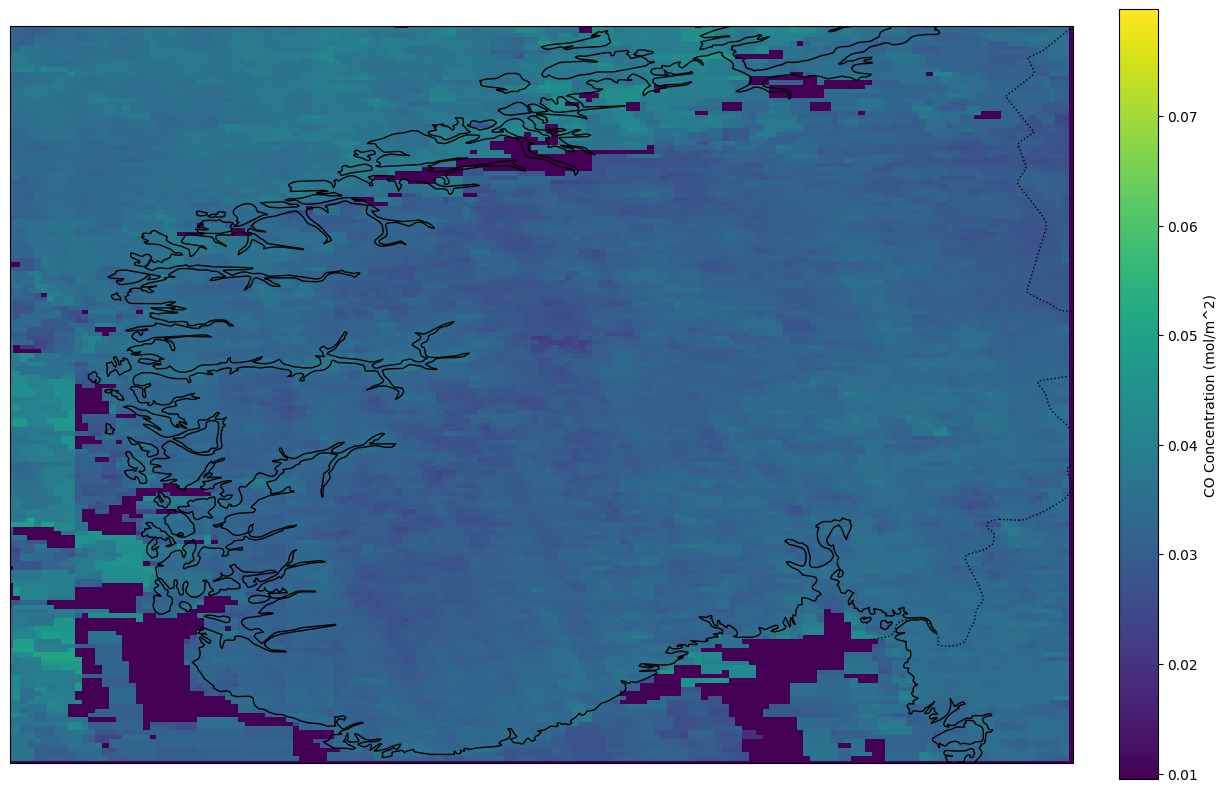

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import matplotlib.animation as animation

# Specify the path to your Sentinel-5P NetCDF file
file_path = "test5.nc"
dataset = Dataset(file_path)

# Step 1: Extract relevant variables
time = dataset.variables['t'][:]  # Assuming 't' represents time
longitude = dataset.variables['x'][:]  # Longitude
latitude = dataset.variables['y'][:]  # Latitude
co_data = dataset.variables['CO'][:]  # CO concentration (assuming it's 3D: time, lat, lon)

# Step 2: Calculate the global min and max for normalization
co_min = np.min(co_data)
co_max = np.max(co_data)

# Step 3: Calculate weekly average of the CO data (every 7 days)
n_days = 7
n_weeks = len(time) // n_days  # Number of full weeks in the dataset

# Initialize an empty array to store the weekly averaged data
weekly_data = np.empty((n_weeks, len(latitude), len(longitude)))

for i in range(n_weeks):
    # Average over every 7 days
    weekly_data[i, :, :] = np.mean(co_data[i * n_days:(i + 1) * n_days, :, :], axis=0)

# Step 4: Set up the plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map extent
ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()])

# Initial plot for the first time step, with normalized color scale
mesh = ax.pcolormesh(longitude, latitude, weekly_data[0, :, :], transform=ccrs.PlateCarree(),
                     cmap='viridis', vmin=co_min, vmax=co_max)

# Add a colorbar with static limits
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('CO Concentration (mol/m^2)')

# Step 5: Animation update function
def update_frame(frame):
    ax.set_title(f'Sentinel-5P CO Concentration - Week {frame + 1}', fontsize=16)
    
    # Clear the existing mesh plot (but keep map features)
    global mesh
    mesh.remove()
    
    # Update mesh for the current time step (weekly data), using the static color scale
    mesh = ax.pcolormesh(longitude, latitude, weekly_data[frame, :, :], transform=ccrs.PlateCarree(),
                         cmap='viridis', vmin=co_min, vmax=co_max)
    return mesh,

# Step 6: Animate the plot from t=0 to t=end (use the number of weeks)
ani = animation.FuncAnimation(fig, update_frame, frames=n_weeks, interval=200, repeat=True, blit=False)

# Keep the animation in memory to avoid garbage collection
plt.show()

# Close the dataset when done
dataset.close()

/opt/conda/lib/python3.11/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


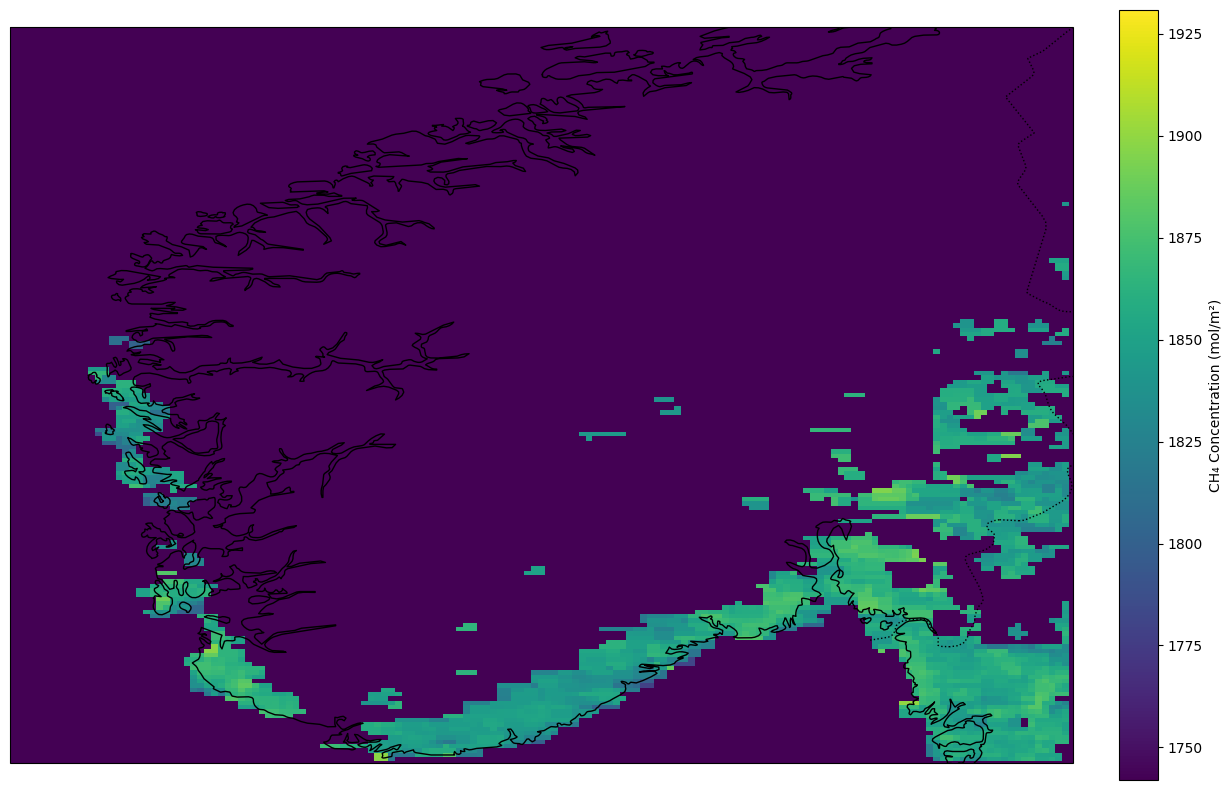

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import matplotlib.animation as animation

# Specify the path to your Sentinel-5P NetCDF file
file_path = "t1CH4.nc"
dataset = Dataset(file_path)

# Step 1: Extract relevant variables
time = dataset.variables['t'][:]  # Assuming 't' represents time
longitude = dataset.variables['x'][:]  # Longitude
latitude = dataset.variables['y'][:]  # Latitude
ch4_data = dataset.variables['CH4'][:]  # CH4 concentration (assuming it's 3D: time, lat, lon)

# Step 2: Calculate the global min and max for normalization
ch4_min = np.min(ch4_data)
ch4_max = np.max(ch4_data)

# Step 3: Calculate weekly average of the CH4 data (every 7 days)
n_days = 7
n_weeks = len(time) // n_days  # Number of full weeks in the dataset

# Initialize an empty array to store the weekly averaged data
weekly_data = np.empty((n_weeks, len(latitude), len(longitude)))

for i in range(n_weeks):
    # Average over every 7 days
    weekly_data[i, :, :] = np.mean(ch4_data[i * n_days:(i + 1) * n_days, :, :], axis=0)

# Step 4: Set up the plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map extent
ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()])

# Initial plot for the first time step, with normalized color scale
mesh = ax.pcolormesh(longitude, latitude, weekly_data[0, :, :], transform=ccrs.PlateCarree(),
                     cmap='viridis', vmin=ch4_min, vmax=ch4_max)

# Add a colorbar with static limits
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('CH₄ Concentration (mol/m²)')

# Step 5: Animation update function
def update_frame(frame):
    ax.set_title(f'Sentinel-5P CH₄ Concentration - Week {frame + 1}', fontsize=16)
    
    # Clear the existing mesh plot (but keep map features)
    global mesh
    mesh.remove()
    
    # Update mesh for the current time step (weekly data), using the static color scale
    mesh = ax.pcolormesh(longitude, latitude, weekly_data[frame, :, :], transform=ccrs.PlateCarree(),
                         cmap='viridis', vmin=ch4_min, vmax=ch4_max)
    return mesh,

# Step 6: Animate the plot from t=0 to t=end (use the number of weeks)
ani = animation.FuncAnimation(fig, update_frame, frames=n_weeks, interval=200, repeat=True, blit=False)

# Keep the animation in memory to avoid garbage collection
plt.show()

# Close the dataset when done
dataset.close()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import matplotlib.animation as animation

# Specify the path to your Sentinel-5P NetCDF file
file_path = "t1NO2.nc"
dataset = Dataset(file_path)

# Step 1: Extract relevant variables
time = dataset.variables['t'][:]  # Assuming 't' represents time
longitude = dataset.variables['x'][:]  # Longitude
latitude = dataset.variables['y'][:]  # Latitude
no2_data = dataset.variables['NO2'][:]  # NO2 concentration (assuming it's 3D: time, lat, lon)

# Step 2: Calculate the global min and max for normalization
no2_min = np.min(no2_data)
no2_max = np.max(no2_data)

# Step 3: Calculate weekly average of the NO2 data (every 7 days)
n_days = 7
n_weeks = len(time) // n_days  # Number of full weeks in the dataset

# Initialize an empty array to store the weekly averaged data
weekly_data = np.empty((n_weeks, len(latitude), len(longitude)))

for i in range(n_weeks):
    # Average over every 7 days
    weekly_data[i, :, :] = np.mean(no2_data[i * n_days:(i + 1) * n_days, :, :], axis=0)

# Step 4: Set up the plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map extent
ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()])

# Initial plot for the first time step, with normalized color scale
mesh = ax.pcolormesh(longitude, latitude, weekly_data[0, :, :], transform=ccrs.PlateCarree(),
                     cmap='viridis', vmin=no2_min, vmax=no2_max)

# Add a colorbar with static limits
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('NO₂ Concentration (mol/m²)')

# Step 5: Animation update function
def update_frame(frame):
    ax.set_title(f'Sentinel-5P NO₂ Concentration - Week {frame + 1}', fontsize=16)
    
    # Clear the existing mesh plot (but keep map features)
    global mesh
    mesh.remove()
    
    # Update mesh for the current time step (weekly data), using the static color scale
    mesh = ax.pcolormesh(longitude, latitude, weekly_data[frame, :, :], transform=ccrs.PlateCarree(),
                         cmap='viridis', vmin=no2_min, vmax=no2_max)
    return mesh,

# Step 6: Animate the plot from t=0 to t=end (use the number of weeks)
ani = animation.FuncAnimation(fig, update_frame, frames=n_weeks, interval=200, repeat=True, blit=False)

# Keep the animation in memory to avoid garbage collection
plt.show()

# Close the dataset when done
dataset.close()

OSError: [Errno -101] NetCDF: HDF error: 't1NO2.nc'